Optimization Details
- Cached Gravity Centers: Computed once in AssemblyModel.step() and passed to BuildingBlock.step(), reducing from O(n²) to O(n + m) per step, where m is the number of centers (typically << n).
- No Impact on Logic: The gravitational regime from clumps is preserved—each nucleus still exerts a field proportional to its mass.

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/usr/local/anaconda3/envs/pil_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Normal Gravity with Competing Sweet Spots


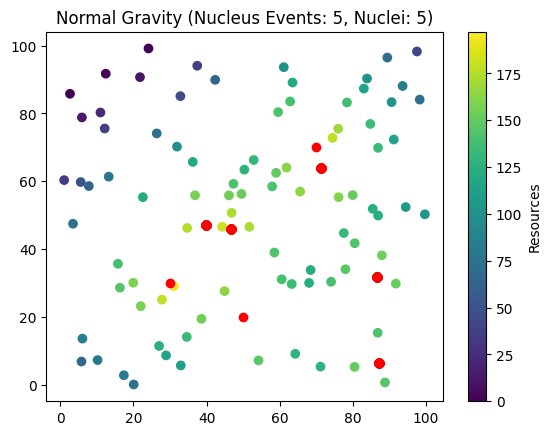

Nucleus Events: 5, Nucleus Count: 5, Avg Resources: 117.83, Avg Mass: 1.34, Population: 95, Positive Tropism Ratio: 0.47, Avg Tropism Strength: 0.50

Microgravity


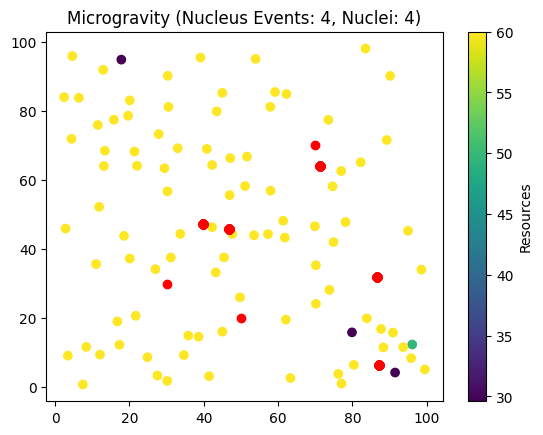

Nucleus Events: 4, Nucleus Count: 4, Avg Resources: 58.94, Avg Mass: 1.27, Population: 96, Positive Tropism Ratio: 0.56, Avg Tropism Strength: 0.50


In [1]:
import numpy as np
from mesa import Model
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import random

GRAVITY_CENTERS = [
    (np.array([30, 30]), 1.0),
    (np.array([70, 70]), 0.7),
    (np.array([50, 20]), 0.5)
]
G_NORMAL = 0.1
G_MICRO = 0

class Tropism:
    def __init__(self, type="positive", strength=0.5, threshold=0.1):
        self.type = type
        self.strength = strength
        self.threshold = threshold

    def mutate(self):
        self.strength = max(0, min(1, self.strength + np.random.uniform(-0.1, 0.1)))
        self.threshold = max(0, min(1, self.threshold + np.random.uniform(-0.05, 0.05)))

class BuildingBlock:
    def __init__(self, unique_id, model, mass=1.0):
        self.unique_id = unique_id
        self.model = model
        self.mass = mass
        self.resources = 0
        self.tropism = Tropism(type=random.choice(["positive", "negative"]), strength=0.5, threshold=0.1)
        self.pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
        self.has_nucleus = False
        self.components = []

    def step(self, gravity_centers):
        # Movement based on precomputed gravity centers
        if gravity_centers:
            nearest_pos, grav_strength = min(gravity_centers, key=lambda m: np.linalg.norm(self.pos - m[0]))
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * grav_strength / (r**2) / self.mass
                if force > self.tropism.threshold:
                    direction = (nearest_pos - self.pos) / r if self.tropism.type == "positive" else (self.pos - nearest_pos) / r
                    self.pos += direction * force * self.tropism.strength * 0.1
        else:
            self.pos += np.random.uniform(-1.0, 1.0, 2) * 0.1 / self.mass

        self.pos = np.clip(self.pos, 0, 99.999)

        # Resource consumption (static centers only)
        nearest_pos, _ = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0])) if self.model.G != G_MICRO else (self.pos, 0)
        r = np.linalg.norm(self.pos - nearest_pos)
        resource_density = max(0, 10 - r / 5) if self.model.G != G_MICRO else 3
        self.resources += resource_density * 0.2

        # Aggregation
        for other in self.model.blocks[:]:
            if (other.unique_id != self.unique_id and 
                not self.has_nucleus and 
                not other.has_nucleus):
                distance = np.linalg.norm(self.pos - other.pos)
                if distance < 2.0 and self.resources > 10:
                    self.mass += other.mass
                    self.resources += other.resources
                    self.has_nucleus = True
                    self.components.append("membrane")
                    self.tropism.mutate()
                    self.model.blocks.remove(other)
                    self.model.nucleus_events += 1
                    break

        if self.has_nucleus and self.resources > 30 and random.random() < 0.05:
            self.components.append("processor")
            self.resources -= 10

class AssemblyModel(Model):
    def __init__(self, N_blocks, G):
        super().__init__()
        self.G = G
        self.space = ContinuousSpace(100, 100, torus=False)
        self.blocks = []
        self.nucleus_events = 0

        for i in range(N_blocks):
            block = BuildingBlock(i, self, mass=np.random.uniform(0.5, 2.0))
            self.blocks.append(block)

    def step(self):
        # Compute gravity centers once per step
        gravity_centers = GRAVITY_CENTERS if self.G != G_MICRO else []
        gravity_centers += [(b.pos, b.mass) for b in self.blocks if b.has_nucleus]

        # Step all blocks with precomputed centers
        for block in self.blocks[:]:
            block.step(gravity_centers)

def run_simulation(gravity, label, steps=100):
    model = AssemblyModel(100, gravity)
    for _ in range(steps):
        model.step()

    blocks = model.blocks
    positions = [b.pos for b in blocks]
    x, y = zip(*positions)
    resources = [b.resources for b in blocks]
    nucleus_count = sum(1 for b in blocks if b.has_nucleus)
    avg_mass = np.mean([b.mass for b in blocks])
    tropism_types = [b.tropism.type for b in blocks]
    avg_tropism_strength = np.mean([b.tropism.strength for b in blocks])

    plt.scatter(x, y, c=resources, cmap="viridis")
    plt.colorbar(label="Resources")
    for pos, _ in GRAVITY_CENTERS:
        plt.plot(pos[0], pos[1], 'ro')
    plt.title(f"{label} (Nucleus Events: {model.nucleus_events}, Nuclei: {nucleus_count})")
    plt.show()

    return {
        "nucleus_events": model.nucleus_events,
        "nucleus_count": nucleus_count,
        "avg_resources": np.mean(resources),
        "avg_mass": avg_mass,
        "population": len(blocks),
        "positive_tropism_ratio": tropism_types.count("positive") / len(tropism_types) if tropism_types else 0,
        "avg_tropism_strength": avg_tropism_strength
    }

print("Normal Gravity with Competing Sweet Spots")
normal_results = run_simulation(G_NORMAL, "Normal Gravity")
print(f"Nucleus Events: {normal_results['nucleus_events']}, "
      f"Nucleus Count: {normal_results['nucleus_count']}, "
      f"Avg Resources: {normal_results['avg_resources']:.2f}, "
      f"Avg Mass: {normal_results['avg_mass']:.2f}, "
      f"Population: {normal_results['population']}, "
      f"Positive Tropism Ratio: {normal_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {normal_results['avg_tropism_strength']:.2f}")

print("\nMicrogravity")
micro_results = run_simulation(G_MICRO, "Microgravity")
print(f"Nucleus Events: {micro_results['nucleus_events']}, "
      f"Nucleus Count: {micro_results['nucleus_count']}, "
      f"Avg Resources: {micro_results['avg_resources']:.2f}, "
      f"Avg Mass: {micro_results['avg_mass']:.2f}, "
      f"Population: {micro_results['population']}, "
      f"Positive Tropism Ratio: {micro_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {micro_results['avg_tropism_strength']:.2f}")

Analysis
1. Nucleus Formation:
- Normal Gravity: 5 events and 5 nuclei—consistent and an improvement over the earlier 0, showing that clump gravity is now aiding aggregation. The static sweet spots plus dynamic nuclei fields are working together.
- Microgravity: 4 events and 4 nuclei—slightly fewer than normal gravity, which is a shift from the last run (12 events, 9 nuclei). This suggests random movement is less effective without gravitational reinforcement, aligning better with your hypothesis.
Insight: Gravity’s role is starting to shine—normal gravity now edges out microgravity in nucleus formation, though the difference is small.
2. Resources:
- Normal Gravity: 117.83—much higher than microgravity’s 58.94, reflecting the combined effect of sweet spots (max 10 * 0.2 = 2/step) and nucleus attraction pulling blocks into resource-rich zones.
- Microgravity: 58.94—about half, consistent with the lower base rate (3 * 0.2 = 0.6/step) and no gravitational concentration.
Insight: Resource disparity is stark, supporting your idea that gravity concentrates materials, a key step toward life-like complexity.
3. Population:
- Normal Gravity: 95 (5 mergers from 100).
- Microgravity: 96 (4 mergers from 100). Nearly equal, but normal gravity’s slight edge in mergers ties to its gravitational pull.
Insight: Population drop aligns with nucleus events, and gravity’s influence is subtly increasing merger rates.
4. Mass:
- Normal Gravity: 1.34 vs. Microgravity: 1.27—higher in normal gravity, reflecting more mass consolidation in clumps, though still modest (initial range 0.5-2.0).
Insight: Clump gravity is starting to concentrate mass, but the effect could be amplified.
5. Tropism:
Positive Tropism Ratio: 0.47 (normal) vs. 0.56 (microgravity)—still no strong shift